In [2]:
#Importação de bibliotecas
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openslide #para carregar os ficheiros .svs
import random
import os
import imageio.v2 as imageio
from PIL import Image
from tqdm import tqdm  # barra de progresso
from collections import defaultdict, Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, auc as calc_auc, precision_recall_curve,  average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, GroupKFold
from sklearn.utils.class_weight import compute_class_weight
from skimage.transform import resize
import itertools
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models, callbacks, optimizers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout,  GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (EarlyStopping, ReduceLROnPlateau, ModelCheckpoint)
from tensorflow.keras.utils import to_categorical



2025-06-10 01:30:33.646201: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


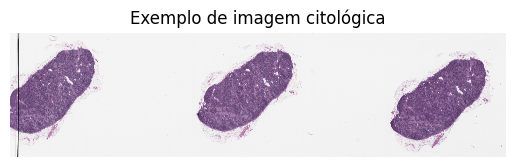

In [4]:
#carregar e visualizar as imagens 

# Caminho para a pasta onde estão os ficheiros .svs
image_folder = "/Volumes/PHILIPS_UFD/SLN-Breast"
image_files = os.listdir(image_folder)

# Aumentar o limite de pixels para evitar o erro DecompressionBombError
Image.MAX_IMAGE_PIXELS = None

#Carregar e mostrar uma imagem de exemplo
img_path = os.path.join(image_folder, image_files[0])
img = Image.open(img_path)

plt.imshow(img)
plt.title("Exemplo de imagem citológica")
plt.axis('off')
plt.show()

In [6]:
# Carregar dados suplementares
df = pd.read_csv("/Volumes/PHILIPS_UFD/PKG-SLN-Breast/target.csv")

# Visualizar as primeiras linhas
print(df.head())

# Verificar distribuição das classes
print(df['target'].value_counts())

                     slide  target
0  HobI16-053768896760.svs       1
1  HobI16-072823783181.svs       1
2  HobI16-105105202254.svs       0
3  HobI16-303757967057.svs       0
4  HobI16-334188031493.svs       0
target
0    94
1    36
Name: count, dtype: int64


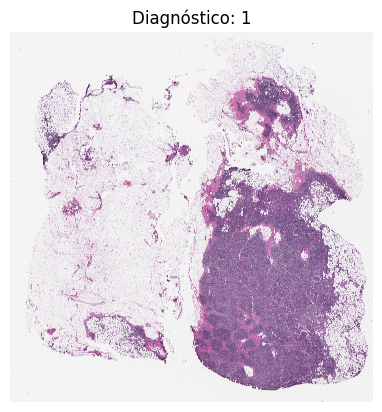

In [7]:
#Combinar as imagens com os dados do CSV
# Exemplo: carregar uma imagem com base no nome no CSV
sample = df.iloc[0]
img_path = os.path.join(image_folder, sample['slide'])
img = Image.open(img_path)

plt.imshow(img)
plt.title(f"Diagnóstico: {sample['target']}")
plt.axis('off')
plt.show()


[INFO] A extrair patches da classe 0...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 0
[INFO] A extrair patches da classe 1...
[AVISO] Imagens acabaram antes de atingir 500 patches para a classe 1
[INFO] Distribuição final de patches por classe:
Classe 0: 438 patches
Classe 1: 365 patches


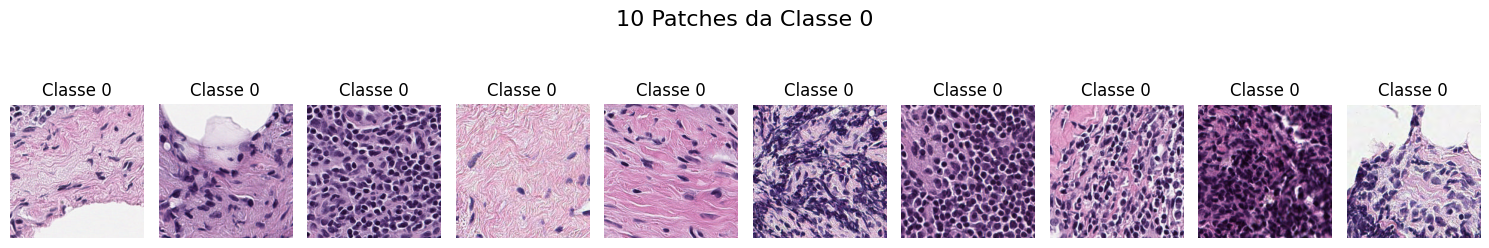

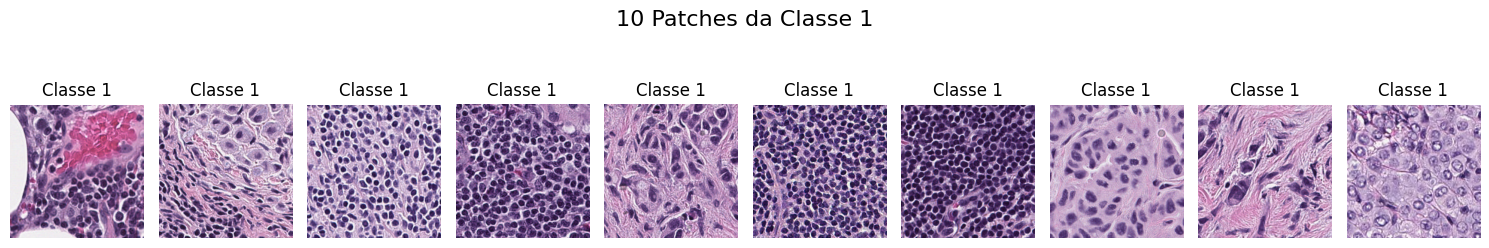

Total patches: 803 | Shape: (803, 224, 224, 3) | Classes: [438 365]
Total slides (grupos) únicos: 128


In [8]:
# ---  Pré-processar cada imagem ---

patch_size = 224
n_patches_por_classe = 500 # número de patches por classe para ajudar a equilibrar o dataset
min_tissue_ratio = 0.6  # número de patches por imagem
min_informacao_threshold = 0.20  # patch médio mais escuro do que isto será ignorado
max_informacao_threshold = 0.80  # evita imagens quase brancas
data = []
counts_per_class = defaultdict(int)

# Agrupar imagens por classe para facilitar a extração balanceada
df_grouped = df.groupby('target')

# Vai  extrair patches para cada classe até atingir n_patches_por_classe
for classe, grupo in df_grouped:
    print(f"[INFO] A extrair patches da classe {classe}...")
    imagens_classe = grupo['slide'].tolist()
    random.shuffle(imagens_classe)
    
    idx_imagem = 0
    while counts_per_class[classe] < n_patches_por_classe:
        if idx_imagem >= len(imagens_classe):
            print(f"[AVISO] Imagens acabaram antes de atingir {n_patches_por_classe} patches para a classe {classe}")
            break
        
        file_path = os.path.join(image_folder, imagens_classe[idx_imagem])
        idx_imagem += 1
        
        try:
            slide = openslide.OpenSlide(file_path)
            slide_w, slide_h = slide.dimensions
            
            patches_collected = 0
            max_attempts = 100
            attempts = 0
            
            while patches_collected < n_patches_por_classe // len(imagens_classe) and attempts < max_attempts:
                x = random.randint(0, slide_w - patch_size)
                y = random.randint(0, slide_h - patch_size)
                
                patch = slide.read_region((x, y), 0, (patch_size, patch_size)).convert("RGB")
                patch_array = np.array(patch) / 255.0  # normalizado para [0, 1]
                
                tissue_ratio = (patch_array.mean(axis=2) < 0.9).mean()
                info_media = patch_array.mean()
                
                # Verifica se o patch tem tecido e não é escuro/danificado
                if tissue_ratio >= min_tissue_ratio and min_informacao_threshold <= info_media <= max_informacao_threshold:
                    slide_id = os.path.basename(file_path) 
                    data.append((patch_array, classe, slide_id))
                    counts_per_class[classe] += 1
                    patches_collected += 1
                attempts += 1
                
        except Exception as e:
            print(f"[ERRO] {file_path}: {e}")

# --- Mostrar distribuição final ---
print("[INFO] Distribuição final de patches por classe:")
for classe, count in counts_per_class.items():
    print(f"Classe {classe}: {count} patches")

# --- Visualizar alguns patches por classe ---
def mostrar_patches_por_classe(data, n=5):
    """
    Mostra n patches aleatórios para cada classe presentes em 'data'.
    """
    classes = set(label for (_, label, _) in data)
    for classe in classes:
        patches_classe = []
        for img, label, slide_id in data:
            if label == classe:
                patches_classe.append(img)

        num_to_show = min(n, len(patches_classe))
        amostras = random.sample(patches_classe, num_to_show)
        plt.figure(figsize=(15, 3))

        for i, patch in enumerate(amostras):
            plt.subplot(1, num_to_show, i + 1)
            plt.imshow(patch)
            plt.title(f"Classe {classe}")
            plt.axis('off')
        plt.suptitle(f"{num_to_show} Patches da Classe {classe}", fontsize=16)
        plt.tight_layout()
        plt.show()

# Chamar a função para visualizar os patches
mostrar_patches_por_classe(data, n=10)

# Converter para arrays numpy
X      = np.array([img   for img, _, _     in data])
y      = np.array([lbl   for _, lbl, _     in data])
groups = np.array([gid   for _, _, gid     in data])
print(f"Total patches: {len(X)} | Shape: {X.shape} | Classes: {np.bincount(y)}")
print(f"Total slides (grupos) únicos: {len(np.unique(groups))}")

Counter({0: 350, 1: 292}) Counter({0: 88, 1: 73})
Imagens guardadas no treino: {'0': 350, '1': 292}
Imagens guardadas no teste: {'0': 88, '1': 73}
Imagens do conjunto de treino:


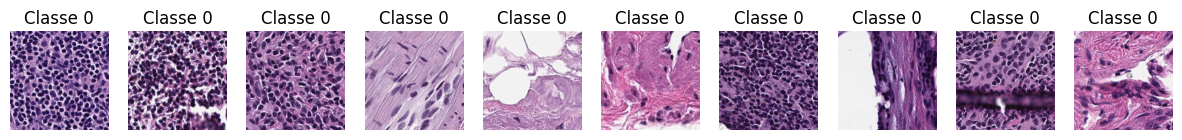

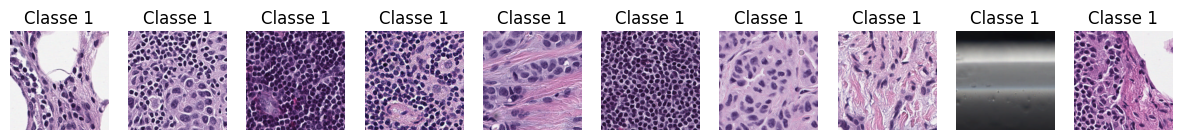

Imagens do conjunto de teste:


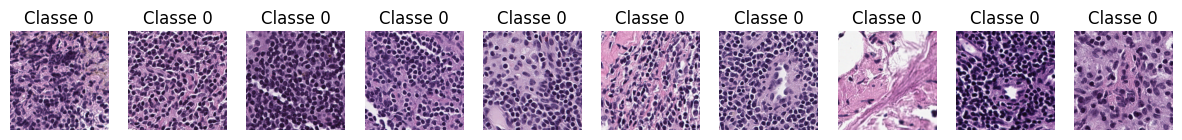

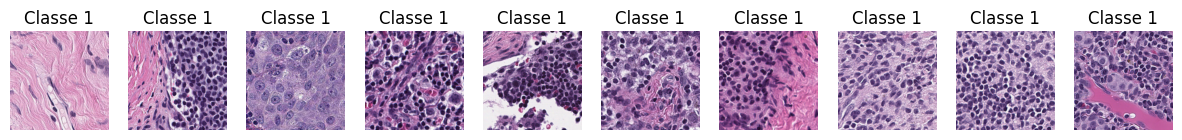

In [10]:
#Deep learning
# --- Dividir e guardar patches em diretórios ---
base_dir = "/Volumes/PHILIPS_UFD/PKG-SLN-Breast"
train_dir, test_dir = os.path.join(base_dir, "train"), os.path.join(base_dir, "test")
for d in [train_dir, test_dir]:
    for c in ["0", "1"]:
        os.makedirs(os.path.join(d, c), exist_ok=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

min_informacao_threshold = 0.20  # evitar imagens quase pretas
max_informacao_threshold = 0.85  # evitar imagens quase brancas

def save_patch(patch, label, split, index):
    """
    Guarda um patch se este tiver informação relevante (nem preto nem branco).
    Assume que os patches estão normalizados entre 0 e 1.
    """
    media_info = patch.mean()
    if not (min_informacao_threshold <= media_info <= max_informacao_threshold):
        return

    patch_uint8 = (patch * 255).astype(np.uint8)

    folder = train_dir if split == "train" else test_dir
    class_folder = os.path.join(folder, str(label))
    filename = f"{label}_{index}.png"
    imageio.imwrite(os.path.join(class_folder, filename), patch_uint8)

# Guardar os patches filtrados
for i, (img, label) in enumerate(zip(X_train, y_train)):
    save_patch(img, label, split="train", index=i)

for i, (img, label) in enumerate(zip(X_test, y_test)):
    save_patch(img, label, split="test", index=i)

print(Counter(y_train), Counter(y_test))

#Garantir que as imagens foram guardadas corretamente
def count_saved_images(directory):
    counts = {}
    for label in ["0", "1"]:
        folder = os.path.join(directory, label)
        counts[label] = len(os.listdir(folder))
    return counts

print("Imagens guardadas no treino:", count_saved_images(train_dir))
print("Imagens guardadas no teste:", count_saved_images(test_dir))

# Função para mostrar imagens aleatórias de cada classe
def show_random_images(directory, class_label, num_images=10):
    folder = os.path.join(directory, class_label)
    images = os.listdir(folder)
    selected_images = random.sample(images, min(num_images, len(images)))

    plt.figure(figsize=(15, 5))
    for i, image_name in enumerate(selected_images):
        img_path = os.path.join(folder, image_name)
        image = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Classe {class_label}")
        plt.axis('off')
    plt.show()

# Mostrar imagens do conjunto de treino
print("Imagens do conjunto de treino:")
show_random_images(train_dir, "0")
show_random_images(train_dir, "1")

# Mostrar imagens do conjunto de teste
print("Imagens do conjunto de teste:")
show_random_images(test_dir, "0")
show_random_images(test_dir, "1")



--- Fold 1/5 ---
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step

--- Fold 2/5 ---

--- Fold 3/5 ---

--- Fold 4/5 ---

--- Fold 5/5 ---
Epoch 1/10
41/41 - 94s - 2s/step - accuracy: 0.4743 - auc: 0.4707 - loss: 0.6996 - val_accuracy: 0.5375 - val_auc: 0.4676 - val_loss: 0.6911 - learning_rate: 1.0000e-04
Epoch 2/10
41/41 - 73s - 2s/step - accuracy: 0.4790 - auc: 0.4805 - loss: 0.6968 - val_accuracy: 0.5375 - val_auc: 0.4761 - val_loss: 0.6905 - learning_rate: 1.0000e-04
Epoch 3/10
41/41 - 87s - 2s/step - accuracy: 0.5117 - auc: 0.5248 - loss: 0.6927 - val_accuracy: 0.4812 - val_auc: 0.4844 - val_loss: 0.6942 - learning_rate: 1.0000e-04
Epoch 4/10
41/41 - 60s - 1s/step - accuracy: 0.5101 - auc: 0.4920 - loss: 0.6979 - val_accuracy: 0.5375 - val_auc: 0.4771 - val_loss: 0.6925 - learning_rate: 1.0000e-04
Epoch 5/10
41/41 - 58s - 1s/step - accuracy: 0.5148 - auc: 0.5208 - loss: 0.6942 - val_accuracy: 0.4625 - val_auc: 0.4766 - val_loss: 0.6952 - learning_rate: 1.0000e-04
Epoch 6/10
41/

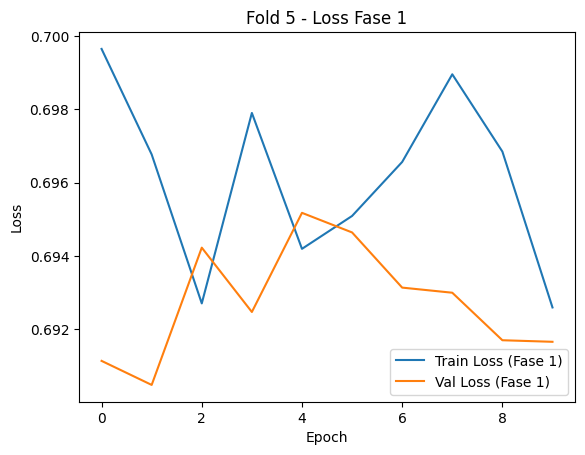

Epoch 1/10
41/41 - 299s - 7s/step - accuracy: 0.4868 - auc: 0.5451 - loss: 0.7075 - val_accuracy: 0.4625 - val_auc: 0.5000 - val_loss: 0.6950 - learning_rate: 1.0000e-05
Epoch 2/10
41/41 - 231s - 6s/step - accuracy: 0.5148 - auc: 0.5876 - loss: 0.6904 - val_accuracy: 0.4625 - val_auc: 0.4912 - val_loss: 0.7029 - learning_rate: 1.0000e-05
Epoch 3/10


In [ ]:
# --- Parâmetros ---
k_folds = 5
batch_size = 16
epochs_initial = 10
epochs_finetune = 10
max_per_slide = 100  # limite de patches por slide

# Normalizar X (se ainda não estiver normalizado)
#X = X.astype('float32') / 255.0

# Preparar o Stratified K-Fold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
auc_scores = []

X = np.array([img for img, _, _ in data])
y = np.array([label for _, label, _ in data])
groups = np.array([sid for _, _, sid in data])

gkf = GroupKFold(n_splits=k_folds)


# Cria um bloco de augmentação com layers do Keras 
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),    # rotações até ±10%
    tf.keras.layers.RandomZoom(0.1),        # zoom até 10%
    tf.keras.layers.RandomContrast(0.1),    # contraste ±10%
])

def make_dataset(X_arr, y_arr, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((X_arr, y_arr))
    if augment:
        ds = ds.shuffle(len(X_arr))
        # aplica a camada de augmentação
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)


for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups=groups), 1):
    print(f"\n--- Fold {fold}/{k_folds} ---")

    #Limitar patches por slide
    slide_ids_train = groups[train_idx]
    selected = []
    for slide in np.unique(slide_ids_train):
        idxs = train_idx[slide_ids_train == slide]
        n = min(len(idxs), max_per_slide)
        selected.extend(np.random.choice(idxs, n, replace=False))
    selected = np.array(selected)

    X_train_cv = X[selected];   y_train_cv = y[selected]
    X_val_cv   = X[val_idx];    y_val_cv   = y[val_idx]

    # Computar class weights
    cw_vals = compute_class_weight('balanced',
                                   classes=np.unique(y_train_cv),
                                   y=y_train_cv)
    class_weights = dict(enumerate(cw_vals))

    # Função para criar o modelo 
    base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224,224,3))
    base.trainable = False
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs=base.input, outputs=out)
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])


    # Callbacks comuns
    cb_list = [
        callbacks.EarlyStopping(monitor='val_auc', patience=3, mode='max', restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.2, patience=2, mode='max', min_lr=1e-7)
    ]

    # Criar datasets com aumentação no treino
    train_ds_cv = make_dataset(X_train_cv, y_train_cv, augment=True)
    val_ds_cv   = make_dataset(X_val_cv,   y_val_cv,   augment=False)

# Fase 1: treinar só a cabeça 
history1 = model.fit(
    train_ds_cv,
    validation_data=val_ds_cv,
    epochs=epochs_initial,
    class_weight=class_weights,
    callbacks=cb_list,
    verbose=2
)

# Plot loss for Fase 1
plt.figure()
plt.plot(history1.history['loss'], label='Train Loss (Fase 1)')
plt.plot(history1.history['val_loss'], label='Val Loss (Fase 1)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Fold {fold} - Loss Fase 1')
plt.legend()
plt.show()

# Fase 2: fine-tuning (descongelar tudo) 
base.trainable = True
model.compile(optimizer=optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

history2 = model.fit(
    train_ds_cv,
    validation_data=val_ds_cv,
    epochs=epochs_finetune,
    class_weight=class_weights,
    callbacks=cb_list,
    verbose=2
)

# Plot loss for Fase 2
plt.figure()
plt.plot(history2.history['loss'], label='Train Loss (Fase 2)')
plt.plot(history2.history['val_loss'], label='Val Loss (Fase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Fold {fold} - Loss Fase 2')
plt.legend()
plt.show()

# --- Avaliação no fold ---
y_pred_proba = model.predict(val_ds_cv).ravel()
auc = roc_auc_score(y_val_cv, y_pred_proba)
auc_scores.append(auc)
print(f"Fold {fold} AUC: {auc:.4f}")

# Matriz de confusão
y_pred = (y_pred_proba > 0.5).astype(int)
cm = confusion_matrix(y_val_cv, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Fold {fold} Confusion Matrix")
plt.xlabel("Previsto"); plt.ylabel("Real")
plt.show()


Loss: 0.699 | Accuracy: 0.457 | AUC: 0.492
11/11 ━━━━━━━━━━━━━━━━━━━━ 8s 501ms/step
AUC-ROC (sklearn): 0.494
Threshold ótimo: 0.534


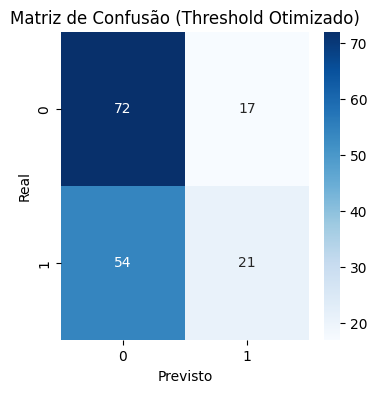

              precision    recall  f1-score   support

           0       0.57      0.81      0.67        89
           1       0.55      0.28      0.37        75

    accuracy                           0.57       164
   macro avg       0.56      0.54      0.52       164
weighted avg       0.56      0.57      0.53       164



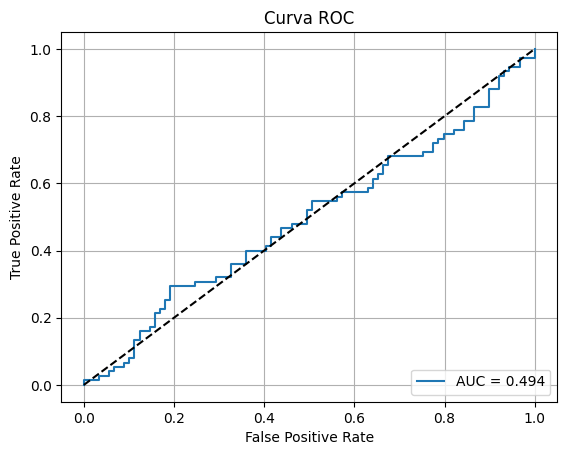

In [18]:
# --- Avaliação geral no conjunto de teste (X_test, y_test) ---
results = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
# Se tens duas métricas além da loss, vai devolver [loss, accuracy, auc]
loss, acc, auc = results  
print(f"Loss: {loss:.3f} | Accuracy: {acc:.3f} | AUC: {auc:.3f}")

# --- Previsões ---
y_probs = model.predict(X_test, batch_size=batch_size).ravel()    # probabilidades
y_true  = y_test                                                 # rótulos reais

# --- AUC-ROC ---
roc_auc = roc_auc_score(y_true, y_probs)
print(f"AUC-ROC (sklearn): {roc_auc:.3f}")

# --- Curva ROC e Threshold ótimo ---
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
opt_idx = np.argmax(tpr - fpr)
opt_thr = thresholds[opt_idx]
print(f"Threshold ótimo: {opt_thr:.3f}")

# --- Previsões binárias com threshold otimizado ---
y_pred_opt = (y_probs > opt_thr).astype(int)

# --- Matriz de Confusão (otimizada) ---
cm = confusion_matrix(y_true, y_pred_opt)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão (Threshold Otimizado)")
plt.show()

# --- Relatório de Classificação ---
print(classification_report(y_true, y_pred_opt, target_names=['0','1']))

# --- Plot da Curva ROC ---
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()